In [145]:
import networkx as nx
import random
import numpy as np
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, PULP_CBC_CMD

import matplotlib.pyplot as plt

Sources: [0]
Sinks: [1, 2, 4]
Transit: []
Demand: {1: 7, 2: 11, 4: 11}


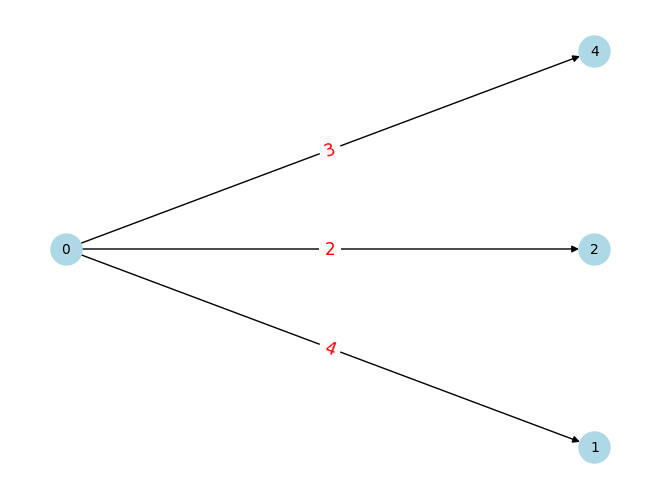

In [149]:
# Parameters
n, p = 5, 0.25
c_min, c_max = 2, 5
D_min, D_max = 5, 15

# Create and configure the graph
G = nx.gnp_random_graph(n, p, directed=True)
G = nx.DiGraph([(u, v, {'c': random.randint(c_min, c_max)}) for u, v in G.edges() if u < v])

# Ensure the graph is a DAG and weakly connected
assert nx.is_directed_acyclic_graph(G)
assert nx.is_weakly_connected(G)

# Identify nodes
sources = [n for n in G.nodes if G.in_degree(n) == 0]
sinks = [n for n in G.nodes if G.out_degree(n) == 0]
transit = [n for n in G.nodes if G.in_degree(n) != 0 and G.out_degree(n) != 0]
demand = {sink: random.randint(D_min, D_max) for sink in sinks}

print(f'Sources: {sources}')
print(f'Sinks: {sinks}')
print(f'Transit: {transit}')
print(f'Demand: {demand}')

# Assign demand to sink nodes
nx.set_node_attributes(G, demand, 'D')

# Set layer attribute for topological sorting
layer_dict = {node: layer for layer, nodes in enumerate(nx.topological_generations(G)) for node in nodes}
nx.set_node_attributes(G, layer_dict, 'layer')

# Draw the graph
pos = nx.multipartite_layout(G, subset_key="layer")
edge_labels = nx.get_edge_attributes(G, 'c')

nx.draw(G, with_labels=True, pos=pos, node_color='lightblue', node_size=500, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12)

plt.show()

In [155]:
# Step 3: Set up the PuLP optimization model
prob = LpProblem("MaxFlow", LpMaximize)

# Step 4: Define the flow variables for each edge
flow_vars = {(u, v): LpVariable(f"x_{u}_{v}", lowBound=0, upBound=G[u][v]['c']) for (u, v) in G.edges()}

# Step 5: Add the flow conservation constraints at each node
for node in G.nodes:
    inflow = lpSum([flow_vars[u, v] for (u, v) in G.in_edges(node)])
    outflow = lpSum([flow_vars[u, v] for (u, v) in G.out_edges(node)])
    
    if node in sources:
        prob += outflow - inflow >= 0, f"flow_conservation_source_{node}"
    elif node in sinks:
        demand = G.nodes[node].get('demand', 0)
        prob += inflow - outflow >= 0, f"flow_conservation_sink_{node}"
        prob += inflow >= demand, f"demand_satisfaction_{node}"
    else:
        prob += inflow == outflow, f"flow_conservation_transit_{node}"

# Step 6: Define the objective function to maximize the flow from sources to sinks
source_outflow = lpSum([flow_vars[u, v] for u in sources for v in G.successors(u)])
prob += source_outflow, "Maximize total flow from sources"

print(f'\nObjective: \n{prob.objective}')

print("\nConstraints:")
for constraint in prob.constraints.values():
    print(constraint)

# Step 7: Solve the optimization problem
prob.solve(PULP_CBC_CMD(msg=False))

# Step 8: Display the results
print(f"\nStatus: {prob.status}")

# Extract flow values
flow_values = {(u, v): flow_vars[u, v].varValue for (u, v) in G.edges()}

# Print the flow on each edge
print("\nSolution:")
for (u, v) in G.edges():
    print(f"Flow from {u} to {v}: {flow_values[(u, v)]}")


Objective: 
x_0_1 + x_0_2 + x_0_4

Constraints:
x_0_1 + x_0_2 + x_0_4 >= 0
x_0_1 >= 0
x_0_1 >= 0
x_0_2 >= 0
x_0_2 >= 0
x_0_4 >= 0
x_0_4 >= 0

Status: 1

Solution:
Flow from 0 to 1: 4.0
Flow from 0 to 2: 2.0
Flow from 0 to 4: 3.0


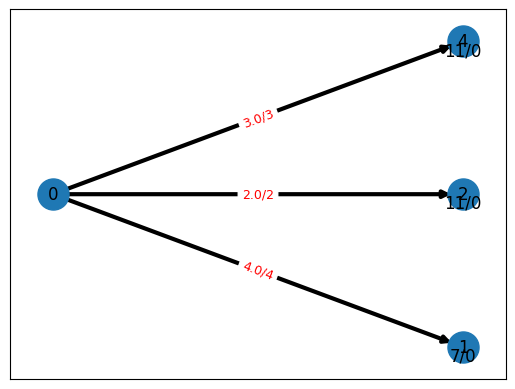

In [159]:
# Create the edge widths based on flow
edge_widths = [(max(flow, 0.1) / G[u][v]['c']) * 3 for ((u, v), flow) in flow_values.items()]

# Draw nodes and edges with customized attributes
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_labels(G, pos, font_size=12)

# Draw edges with thickness and color based on flow
edges = G.edges()
edge_labels = nx.get_edge_attributes(G, 'c')

# Draw edges with widths proportional to the flow
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths)

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels={e: f"{flow_values[e]}/{G[e[0]][e[1]]['c']}" for e in edges}, font_color='red', font_size=9)

sink_labels = {sink: f"{G.nodes[sink].get('D', 0)}/{flow_values.get(('None', sink), 0)}" for sink in sinks}
nx.draw_networkx_labels(G, pos, labels=sink_labels, font_size=12, verticalalignment='top')


plt.show()